In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
from transaction_simulator import *

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# 1.) Load parameters

In [4]:
import sys
from datawand.parametrization import ParamHelper

In [5]:
ph = ParamHelper('..', 'LNGraph', sys.argv)

['/home/fberes/anaconda3/envs/dm-3-env/lib/python3.5/site-packages/ipykernel/__main__.py', '-f', '/run/user/51880/jupyter/kernel-34dbac19-eafe-4d57-9980-7c9cf46a1f4a.json']
/home/fberes/git/LNDynamicTopology
/home/fberes/git/LNDynamicTopology
Default parameters:
{'weight': None, 'num_transactions': 1000, 'amount_sat': 100000, 'weight_cols': [None, 'num_channels', 'capacity', 'fee_base_msat', 'fee_rate_milli_msat'], 'data_dir': '/mnt/idms/fberes/data/bitcoin_ln_research', 'snapshot_id': 0, 'snapshot_ids': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'experiment_id': 'trial'}
Custom parameters:
{}


In [6]:
experiment_id = ph.get("experiment_id")
snapshot_id = ph.get("snapshot_id")
amount_sat = 200000#15USD #ph.get("amount_sat")
num_transactions = 20000#ph.get("num_transactions")

Using default parameter: experiment_id=trial
Using default parameter: snapshot_id=0


In [7]:
data_dir = ph.get("data_dir")
output_dir = "%s/simulations/%s" % (data_dir, snapshot_id)
print(output_dir)

Using default parameter: data_dir=/mnt/idms/fberes/data/bitcoin_ln_research
/mnt/idms/fberes/data/bitcoin_ln_research/simulations/0


In [8]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [9]:
output_file = "%s/%s.csv" % (output_dir, experiment_id)

# 2.) Load data

In [10]:
snapshots = pd.read_csv("%s/directed_temporal_edges.csv" % data_dir)

In [11]:
node_meta = pd.read_csv("%s/node_meta_with_labels.csv" % data_dir)

In [12]:
providers = list(node_meta["pub_key"])
len(providers)

181

In [13]:
snapshots.head()

,src,trg,snapshot_id,num_channels,capacity,fee_base_msat,fee_rate_milli_msat
0,0200072fd301cb4a680f26d87c28b705ccd6a1d5b00f1b...,02004c625d622245606a1ea2c1c69cfb4516b703b47945...,7,1,1000000,1000.0,1.0
1,0200072fd301cb4a680f26d87c28b705ccd6a1d5b00f1b...,0202497639162bf2b608152aa2659c4dbd25bb0d3fbd5c...,4,1,500000,1000.0,1.0
2,0200072fd301cb4a680f26d87c28b705ccd6a1d5b00f1b...,0202497639162bf2b608152aa2659c4dbd25bb0d3fbd5c...,5,1,500000,1000.0,1.0
3,0200072fd301cb4a680f26d87c28b705ccd6a1d5b00f1b...,0202497639162bf2b608152aa2659c4dbd25bb0d3fbd5c...,6,1,500000,1000.0,1.0
4,0200072fd301cb4a680f26d87c28b705ccd6a1d5b00f1b...,0202497639162bf2b608152aa2659c4dbd25bb0d3fbd5c...,7,1,500000,1000.0,1.0


In [14]:
edges = snapshots[snapshots["snapshot_id"]==snapshot_id]

# 3.) Simulation

In [15]:
simulator = TransactionSimulator(edges, providers, amount_sat, num_transactions)

Number of deleted directed channels: 10928
Number of remaining directed channels: 30890


/home/fberes/git/LNDynamicTopology/feri_sandbox/transaction_simulator.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.edges["total_fee"] = self.edges["fee_base_msat"] / 1000.0 + amount_sat * self.edges["fee_rate_milli_msat"] / 10.0**6


Number of loop transactions (removed): 1
20000 transaction were generated.


simulator.transactions

simulator.transactions["source"].value_counts()[:10]

simulator.transactions["target"].value_counts()[:10]

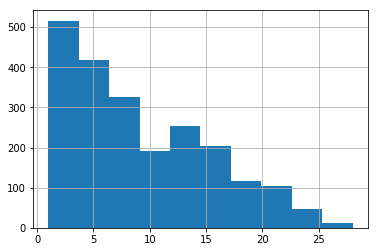

In [16]:
simulator.transactions["source"].value_counts().hist()

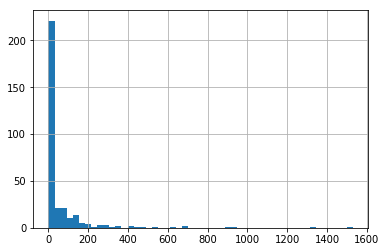

In [17]:
simulator.transactions["target"].value_counts().hist(bins=50)

from tqdm import tqdm
import time

for i, item in enumerate(tqdm(["a","b","c","d"])):
    time.sleep(1)

#### - 10000 trans - 1 thread - 7 min

In [18]:
%%time
shortest_paths, alternative_paths, all_router_fees = simulator.simulate(weight="total_fee", max_threads=8)

Using weight='total_fee'
Transactions simulated on original graph STARTED..
Transactions simulated on original graph DONE
Length distribution of optimal paths:
 3    8845
 2    8406
 4    1781
 1     365
 5     353
-1     209
 6      34
 7       5
 8       1
Name: length, dtype: int64
Transactions simulated with node removals STARTED..
8
Transactions simulated with node removals DONE
Length distribution of optimal paths:
 3    11457
-1    10440
 4     5637
 2     3466
 5     1635
 6      352
 7       64
 8        7
Name: length, dtype: int64
CPU times: user 3min 27s, sys: 11.8 s, total: 3min 38s
Wall time: 3min 57s


In [19]:
shortest_paths.head()

,transaction_id,original_cost,length,path
0,0,0.2,2,[031de60d9f2aa1356f43a3452197d48a0987ae57b1ab8...
1,1,1.2,2,[035af8db31b4e3e3ef8cb948403fce5462b70cc5badbd...
2,2,1.4,3,[02d91a5dbb9202e724c3501338adb511c761e7851e004...
3,3,200.0,2,[03cfff2802946f256dd04549ac191208e5f37687d6995...
4,4,100.9,4,[0372d0986edbdc5c3c6b5e94ee3c56aff6739a1f8b8d2...


In [20]:
alternative_paths.head()

,transaction_id,cost,length,path,node
0,1321,None,-1,[],03817e6563dc36585b4510ff5fa50c0fe9a763ef14aa0b...
1,3313,None,-1,[],03817e6563dc36585b4510ff5fa50c0fe9a763ef14aa0b...
2,4931,None,-1,[],03817e6563dc36585b4510ff5fa50c0fe9a763ef14aa0b...
3,5721,None,-1,[],03817e6563dc36585b4510ff5fa50c0fe9a763ef14aa0b...
4,7936,None,-1,[],03817e6563dc36585b4510ff5fa50c0fe9a763ef14aa0b...


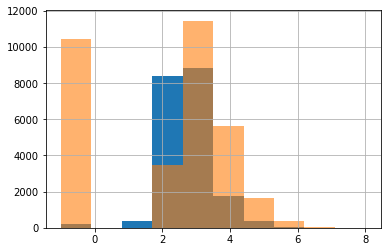

In [21]:
shortest_paths["length"].hist()
alternative_paths["length"].hist(alpha=0.6)

In [22]:
harmonic_sums, routing_differences = calculate_node_influence(shortest_paths, alternative_paths)

harmonic_sums.reset_index().to_csv(output_file, index=False)

In [23]:
harmonic_sums["cost_diff"].mean()

10.811360356663045

In [24]:
harmonic_sums.head(10)

,original_cost,cost,cost_diff
node,,,
02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f0c544b34c1c6f3b9a02b,2391.232553,1612.518686,778.713868
0331f80652fb840239df8dc99205792bba2e559a05469915804c08420230e23c7c,841.092744,188.676825,652.415918
03bb88ccc444534da7b5b64b4f7b15e1eccb18e102db0e400d4b9cfe93763aa26d,1550.984001,1061.658242,489.325759
0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266,516.638904,256.944665,259.694239
03cb7983dc247f9f81a0fa2dfa3ce1c255365f7279c8dd143e086ca333df10e278,325.680595,101.380796,224.299799
020d41c5a32f06d7addc7378f2d4a6596358d8716a3eb5d5bbdd894a82a1fdd00c,117.838320,27.380162,90.458157
03c436af41160a355fc1ed230a64f6a64bcbd2ae50f12171d1318f9782602be601,226.342482,138.368028,87.974454
030c3f19d742ca294a55c00376b3b355c3c90d61c6b6b39554dbc7ac19b141c14f,172.378985,88.788454,83.590530
0327049d8d63f0c40193cdf3afc61817c8647808a4e482de0716fcef74e6d92ebf,105.491076,23.010480,82.480596


harmonic_sums.tail(10)

# 4. Total income for routing nodes

In [25]:
total_income = all_router_fees.groupby("node")["fee"].sum().sort_values(ascending=False)

#### Top nodes monthly income is 30*13 USD = 390 USD ~ 100K HUF / month - reasonable?

In [26]:
total_income.head(10)

node
0232e20e7b68b9b673fb25f48322b151a93186bffe4550045040673797ceca43cf    166083.0
03a503d8e30f2ff407096d235b5db63b4fcf3f89a653acb6f43d3fc492a7674019    105384.5
03e50492eab4107a773141bb419e107bda3de3d55652e6e1a41225f06a0bbf2d56     69138.0
03d37fca0656558de4fd86bbe490a38d84a46228e7ec1361801f54f9437a18d618     51054.0
0279c22ed7a068d10dc1a38ae66d2d6461e269226c60258c021b1ddcdfe4b00bc4     31600.0
03fb822818be083e0a954db85257a2911a3d55458b8c1ea4124b157e865a836d12     16683.0
0390b5d4492dc2f5318e5233ab2cebf6d48914881a33ef6a9c6bcdbb433ad986d0     10954.5
022755c3ff4e5a1d71f573cda4b315887fc00a9e5c9ea9a847d939f3e517e69a70     10753.5
032679fec1213e5b0a23e066c019d7b991b95c6e4d28806b9ebd1362f9e32775cf     10452.0
0303a518845db99994783f606e6629e705cfaf072e5ce9a4d8bf9e249de4fbd019      9949.5
Name: fee, dtype: float64

# 5. Analyze optimal routing fee for nodes

## TODO: Pistitől kell infó, hogy mennyi legyen a megszakadt tranzakció büntetése...

In [27]:
p_altered = alternative_paths[~alternative_paths["cost"].isnull()]

In [28]:
"Path ratio that have alternative routing after removals: %f" % (len(p_altered) / len(alternative_paths))

'Path ratio that have alternative routing after removals: 0.684191'

In [29]:
num_routers = len(alternative_paths["node"].unique())
num_routers_with_alternative_paths = len(p_altered["node"].unique())
"Node ratio that have alternative routing after removals: %f" % (num_routers_with_alternative_paths / num_routers)

'Node ratio that have alternative routing after removals: 0.862140'

In [30]:
def calculate_max_income(n, visualize=False, min_ratio=0.0):
    trans = p_altered[p_altered["node"] == n]
    trans = trans.merge(shortest_paths, on="transaction_id", how="left")#'original_cost' column merged
    trans = trans.merge(all_router_fees, on=["transaction_id","node"], how="left")#'fee' column is merged
    trans["delta_cost"] = trans["cost"] - trans["original_cost"]
    ordered_deltas = trans[["transaction_id","fee","delta_cost"]].sort_values("delta_cost")
    ordered_deltas["delta_cost"] = ordered_deltas["delta_cost"].apply(lambda x: round(x, 2))
    thresholds = sorted(list(ordered_deltas["delta_cost"].unique()))
    original_income = ordered_deltas["fee"].sum()
    original_num_transactions = len(ordered_deltas)
    probas, incomes = [], []
    for th in thresholds:
        df = ordered_deltas[ordered_deltas["delta_cost"] >= th]
        prob = len(df) / original_num_transactions
        total = df["fee"].sum() + len(df) * th
        incomes.append(total)
        probas.append(prob)
        if prob < min_ratio:
            break
    max_idx = np.argmax(incomes)
    if visualize:
        fig, ax1 = plt.subplots()
        ax1.set_title(original_num_transactions)
        ax1.plot(thresholds[:len(incomes)], incomes, 'bx-')
        ax1.plot(thresholds[:len(incomes)], np.array(incomes)*np.array(probas), 'rx-')
        ax2 = ax1.twinx()
        ax2.plot(thresholds[:len(incomes)], probas, 'gx-')
    return thresholds[max_idx], incomes[max_idx], probas[max_idx], original_income, original_num_transactions

## a.) Visualization of optimal routing fee calculation

#### top 5 routers

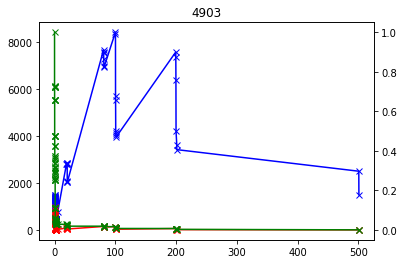

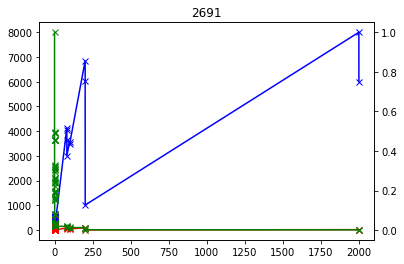

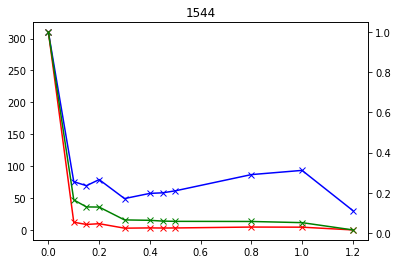

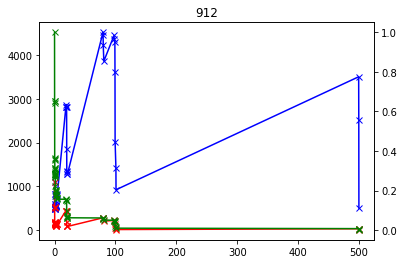

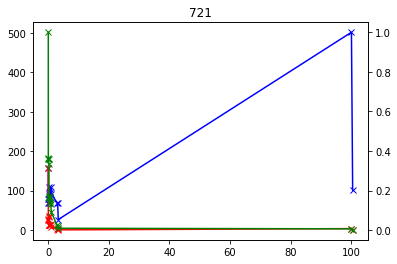

In [43]:
for n in list(p_altered["node"].value_counts()[:5].index):
    _, _, _, _, _ = calculate_max_income(n, visualize=True)

#### rnd 5 routers

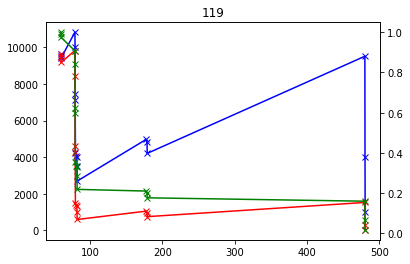

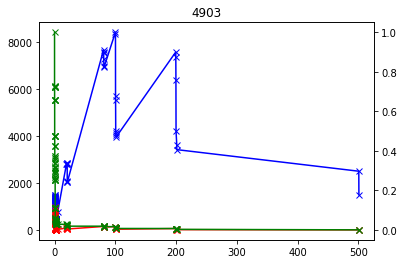

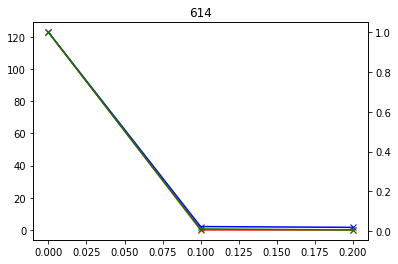

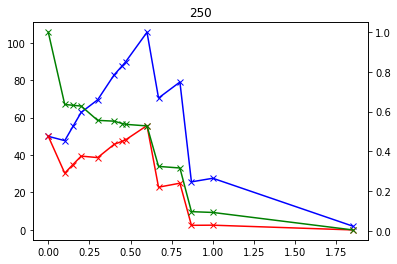

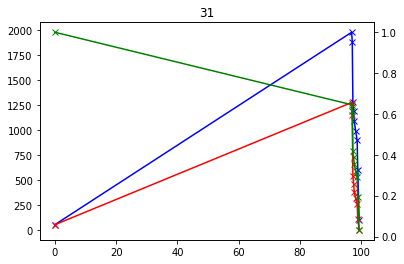

In [45]:
for n in list(p_altered.sample(5)["node"]):
    _, _, _, _, _ = calculate_max_income(n, visualize=True)

## b.) optimal routing fee for all nodes

In [33]:
routers = list(p_altered["node"].unique())

In [34]:
opt_strategy = []
for n in tqdm(routers):
    opt_delta, opt_income, opt_ratio, origi_income, origi_num_trans = calculate_max_income(n, visualize=False)
    opt_strategy.append((n, opt_delta, opt_ratio, opt_income, origi_income, origi_num_trans))

100%|██████████| 419/419 [00:16<00:00, 25.66it/s]


In [35]:
opt_fees_df = pd.DataFrame(opt_strategy, columns=["node","opt_delta","opt_ratio","opt_income","origi_income", "origi_num_trans"])

In [36]:
opt_fees_df["income_gain"] = ((opt_fees_df["opt_income"] - opt_fees_df["origi_income"]) / opt_fees_df["origi_income"]).replace(np.inf, 100.0)

In [37]:
opt_fees_df.head()

,node,opt_delta,opt_ratio,opt_income,origi_income,origi_num_trans,income_gain
0,0336bf99875b31ad9d78f2788d75bcb3deb52ff71ceac1...,0.20,1.0,1.40,1.2,1,0.166667
1,0237480cd2c974bfdb034f4effa8030885c7d3645c0a6e...,5.41,0.7,46.27,12.0,10,2.855833
2,02f08380da84f77ed03fb9310f99c69c50f951cc82a7f2...,0.00,1.0,13.20,13.2,11,0.000000
3,03c73e43e92fab12af3461f723901f0bcdabdfdcf9b749...,99.00,1.0,1002.00,12.0,10,82.500000
4,03842a085b8b89da9db708b83aae8e9baff7a0a6f34368...,0.20,1.0,7.20,0.0,36,100.000000


In [38]:
opt_fees_df[["opt_delta","opt_ratio","opt_income","origi_income","origi_num_trans","income_gain"]].mean()

opt_delta            73.529427
opt_ratio             0.844040
opt_income         1004.963396
origi_income        178.674889
origi_num_trans      53.980907
income_gain          29.987968
dtype: float64

/home/fberes/anaconda3/envs/dm-3-env/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


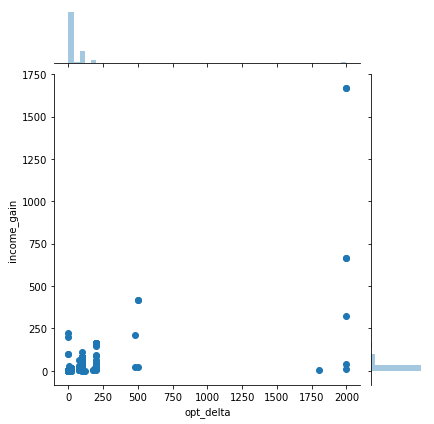

In [40]:
sns.jointplot(data=opt_fees_df, x="opt_delta", y="income_gain")

### Most of the nodes can increase their income without losing too much traffic

/home/fberes/anaconda3/envs/dm-3-env/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


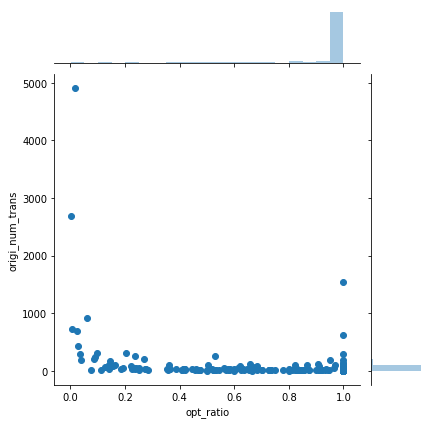

In [39]:
sns.jointplot(data=opt_fees_df, x="opt_ratio", y="origi_num_trans")